# Acea Smart Water Analytics
Can you help preserve "blue gold" using data to predict water availability?

https://www.kaggle.com/c/acea-water-prediction

<img src='https://drive.google.com/uc?id=1A5tbC2L-olO-5QnnOYs10836_Ic3_S_F' width="600" height="300">

## Notebook Preparation

In [5]:
#need to mount drive first
%cd /content/drive/MyDrive/PUC-Minas_ML_AI/15.\ TCC\ Inteligência\ Artificial\ e\ Aprendizado\ de\ Máquina
!ls

/content/drive/MyDrive/PUC-Minas_ML_AI/15. TCC Inteligência Artificial e Aprendizado de Máquina
 1987-Mt.Amiatasprings-JVGR.pdf   ExemploRelatorioTecnico.doc
 Acea_Analysis_2015_2018.ipynb	  Guia-ABNT-relatorios.pdf
 Acea_Analysis_2015_2020.ipynb	 'Kaggle Competitions.gdoc'
 Acea_Analysis_FINAL.ipynb	  logs
 Acea_Analysis.ipynb		  LSTM_for_Water_Spring_Flow_Rates.ipynb
 Acea-Input.png			  mt_amiata.png
 acea-water-prediction		  Referências.gdoc
 amiata_abs_desc.png		  TCC-Final.docx
 DOVERIetalii_amiata.pdf	  weights.h5
 energies-07-07434.pdf


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import datetime
from datetime import date, timedelta

from statsmodels.tsa.seasonal import seasonal_decompose

from sklearn.preprocessing import StandardScaler

In [7]:
# Use seaborn style defaults and set the default figure size
# https://www.dataquest.io/blog/tutorial-time-series-analysis-with-pandas/
sns.set(rc={'figure.figsize':(11, 4)})

## Loading Amiata Dataset

Source: https://www.kaggle.com/c/acea-water-prediction/data?select=Water_Spring_Amiata.csv

In [8]:
#Read CSV
ws_amiata = pd.read_csv("acea-water-prediction/Water_Spring_Amiata.csv")

#Convert Date Field
ws_amiata['Date'] =  pd.to_datetime(ws_amiata['Date'])

#Set Date as Index (Primary Key)
ws_amiata = ws_amiata.set_index('Date')
ws_amiata.sort_index()
ws_amiata = ws_amiata.loc[ws_amiata.index.dropna()]

#Preview
ws_amiata.head(5)

,Rainfall_Castel_del_Piano,Rainfall_Abbadia_S_Salvatore,Rainfall_S_Fiora,Rainfall_Laghetto_Verde,Rainfall_Vetta_Amiata,Depth_to_Groundwater_S_Fiora_8,Depth_to_Groundwater_S_Fiora_11bis,Depth_to_Groundwater_David_Lazzaretti,Temperature_Abbadia_S_Salvatore,Temperature_S_Fiora,Temperature_Laghetto_Verde,Flow_Rate_Bugnano,Flow_Rate_Arbure,Flow_Rate_Ermicciolo,Flow_Rate_Galleria_Alta
Date,,,,,,,,,,,,,,,
2000-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.15,NaN,NaN,NaN,NaN,NaN
2000-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.55,NaN,NaN,NaN,NaN,NaN
2000-03-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.70,NaN,NaN,NaN,NaN,NaN
2000-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.00,NaN,NaN,NaN,NaN,NaN
2000-05-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.60,NaN,NaN,NaN,NaN,NaN


## Data Preprocessing

### Absolute Values


According to Acea Group team, originally the minus sign (-) was meant to indicate the output water from the waterbody (water extracted from the waterbody) while the plus sign (+) was meant to indicate the input water to the waterbody. As not each company respected this convention, it is necessary to consider only the absolute value.
**Source:** https://www.kaggle.com/c/acea-water-prediction/discussion/203144

For this reason, they published a new version of the dataset description file that includes a new sheet that shows for each feature of waterbody the possible values ​​that can assume that is positive or negative and if you can consider them as an absolute value. 
**Source:** https://www.kaggle.com/c/acea-water-prediction/discussion/208467

For this reason, we will be adjusting the data as recommended.
<img src='https://drive.google.com/uc?id=1V8zZ6t4eNwi7K63IKMdV0SIlTgOwrH7S'>

In [9]:
ws_amiata_rainfall_cols = [i for i in list(ws_amiata.columns) if i.startswith('Rainfall_')]
ws_amiata[ws_amiata_rainfall_cols] = ws_amiata[ws_amiata_rainfall_cols].abs()

ws_amiata_depths_cols = [i for i in list(ws_amiata.columns) if i.startswith('Depth_to_Groundwater_')]
ws_amiata[ws_amiata_depths_cols] = ws_amiata[ws_amiata_depths_cols].abs()

ws_amiata_flow_rate_cols = [i for i in list(ws_amiata.columns) if i.startswith('Flow_Rate_')]
ws_amiata[ws_amiata_flow_rate_cols] = ws_amiata[ws_amiata_flow_rate_cols].abs()

ws_amiata_temperatures_cols = [i for i in list(ws_amiata.columns) if i.startswith('Temperature_')]
#nothing to do

### Total Rows and Columns

In [10]:
#Total rows
len(ws_amiata)

7487

In [11]:
#Total columns
len(ws_amiata.columns)

15

### Duplicate Records (Days)

In [12]:
#Amount of duplicated records
len(ws_amiata[ws_amiata.index.duplicated()])

0

### Missing Records (Days)

In [13]:
#Check amount of days missing in the dataset
missing_dates = pd.date_range(start=ws_amiata.index.min(), end=ws_amiata.index.max()).difference(ws_amiata.index)
len(missing_dates)

159

In [14]:
#Checking where the missing data is
missing_dates_df = pd.DataFrame(missing_dates.tolist(),columns=['Dates'])
missing_dates_df.index = pd.to_datetime(missing_dates_df['Dates'],format='%m/%d/%y %I:%M%p')
missing_dates_df.groupby(pd.Grouper(freq='M')).count()

,Dates
Dates,
2020-01-31,6
2020-02-29,6
2020-03-31,6
2020-04-30,6
2020-05-31,6
2020-06-30,6
2020-07-31,25
2020-08-31,25
2020-09-30,24


### Handling Missing Records (Days)

In [15]:
full_idx = pd.date_range(ws_amiata.index.min(), ws_amiata.index.max())
ws_amiata = ws_amiata.reindex(full_idx)

In [16]:
#Check amount of days missing in the dataset
missing_dates = pd.date_range(start=ws_amiata.index.min(), end=ws_amiata.index.max()).difference(ws_amiata.index)
len(missing_dates)

0

### Missing Values (NA)

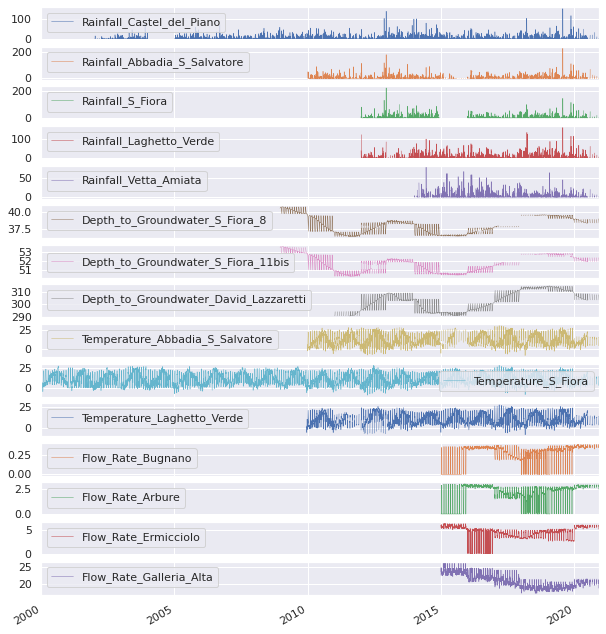

In [17]:
ws_amiata.plot(linewidth=0.5, subplots=True, figsize=(10, 12));

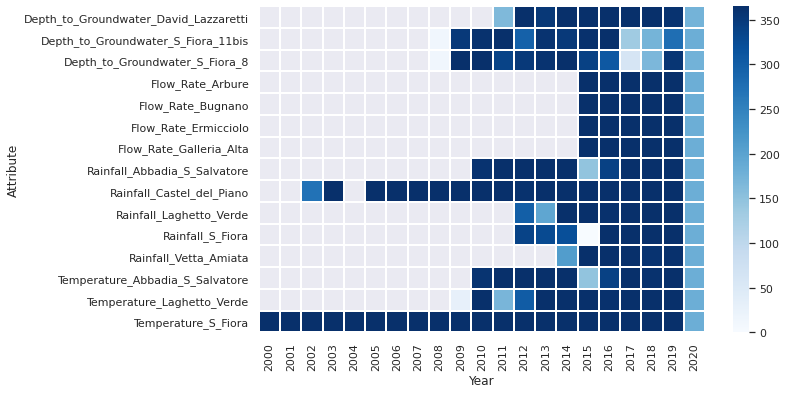

In [18]:
#Understand distribution of days and missing values (NA)
ws_amiata_all_years = pd.DataFrame(columns=['Attribute','Year','N Rows'])
for c in list(ws_amiata.columns):
    for y in set(ws_amiata[c].dropna().index.year):
      n_rows = ws_amiata[c][ws_amiata[c].index.year == y].count()
      ws_amiata_all_years.loc[len(ws_amiata_all_years)] = [c,y,n_rows + 0.0]

ws_amiata_na_pivot = ws_amiata_all_years.pivot(index='Attribute', columns='Year')['N Rows']

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
sns.heatmap(ws_amiata_na_pivot, cmap='Blues', linewidth=1, ax=ax, vmin=0, vmax=365);

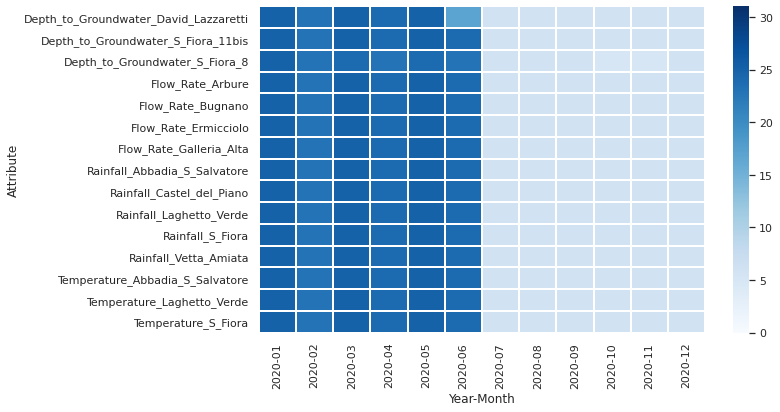

In [19]:
ws_amiata_all_years = pd.DataFrame(columns=['Attribute','Year-Month','N Rows'])
for c in list(ws_amiata.columns):
    for y_m in set(ws_amiata[c].dropna().index.to_period('M')):
      n_rows = ws_amiata[c][ws_amiata[c].index.to_period('M') == y_m].count()
      ws_amiata_all_years.loc[len(ws_amiata_all_years)] = [c,y_m,n_rows + 0.0]

#ws_amiata_all_years['Dummy'] = 1

ws_amiata_2020 = ws_amiata_all_years[ws_amiata_all_years['Year-Month'] > pd.Period('2019-12')]
ws_amiata_na_pivot = ws_amiata_2020.pivot(index='Attribute', columns='Year-Month')['N Rows'] #['Dummy'] 
ws_amiata_na_pivot

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(10,6))
sns.heatmap(ws_amiata_na_pivot, cmap='Blues', linewidth=1, ax=ax, vmin=0, vmax=31);

### Selecting Valid Date Range

As noticed above, even though we have data from 2000, the majority of the attributes only has data after certain date.

For this reason, we will need to select a good range for modeling.

In [20]:
ws_amiata_all_first_dates = pd.DataFrame(columns=['Attribute','First Date','Year'])
ws_amiata_all_last_dates = pd.DataFrame(columns=['Attribute','Last Date','Year'])
for c in list(ws_amiata.columns):
  first_date = ws_amiata[c].dropna().index.min()
  last_date = ws_amiata[c].dropna().index.max()
  ws_amiata_all_first_dates.loc[len(ws_amiata_all_first_dates)] = [c,first_date,first_date.year]
  ws_amiata_all_last_dates.loc[len(ws_amiata_all_last_dates)] = [c,last_date,first_date.year]

ws_amiata_bg = ws_amiata_all_first_dates['First Date'].max()
ws_amiata_ed = ws_amiata_all_last_dates['Last Date'].min()

#ws_amiata_bg = pd.Timestamp(2018, 1, 1, 0)
ws_amiata_ed = pd.Timestamp(2018, 1, 1, 0)

print('Therefore, first date recommended is: ' + str(ws_amiata_bg))
print('Therefore, last date recommended is: ' + str(ws_amiata_ed))

Therefore, first date recommended is: 2015-01-01 00:00:00
Therefore, last date recommended is: 2018-01-01 00:00:00


### Handling Missing Values (NA)

In [21]:
#Check the % of NA records by attribute
ws_amiata_na_perc = pd.DataFrame(columns=['Percentage','Total NA Records'])
for c in list(ws_amiata.columns):
  total = len(ws_amiata.loc[ws_amiata_bg:ws_amiata_ed, c])
  na = ws_amiata.loc[ws_amiata_bg:ws_amiata_ed, c].isna().sum()
  ws_amiata_na_perc.loc[c] = [round(na/total,4)*100 if na > 0 else 0.0,na]

ws_amiata_na_perc = ws_amiata_na_perc.sort_values(by=['Percentage'], ascending=False)
ws_amiata_na_perc

,Percentage,Total NA Records
Depth_to_Groundwater_S_Fiora_8,35.10,385.0
Rainfall_S_Fiora,33.18,364.0
Rainfall_Abbadia_S_Salvatore,22.15,243.0
Temperature_Abbadia_S_Salvatore,21.97,241.0
Depth_to_Groundwater_S_Fiora_11bis,21.33,234.0
Rainfall_Laghetto_Verde,0.27,3.0
Temperature_Laghetto_Verde,0.27,3.0
Rainfall_Castel_del_Piano,0.00,0.0
Rainfall_Vetta_Amiata,0.00,0.0
Depth_to_Groundwater_David_Lazzaretti,0.00,0.0


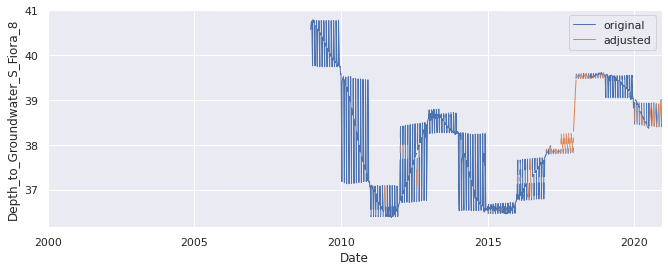

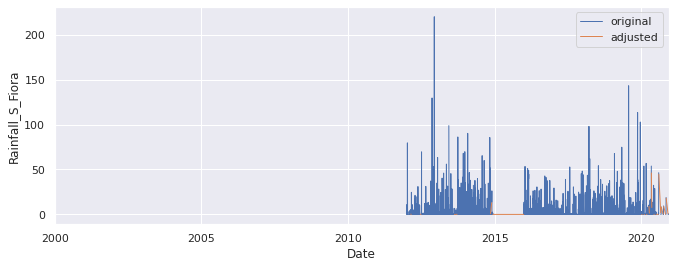

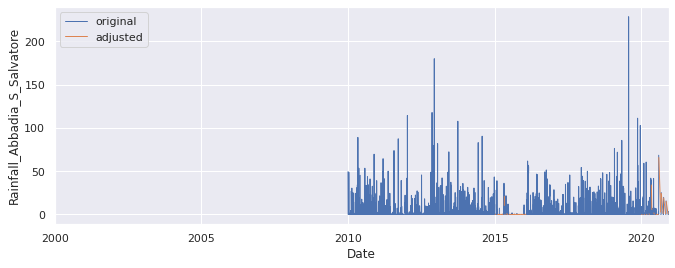

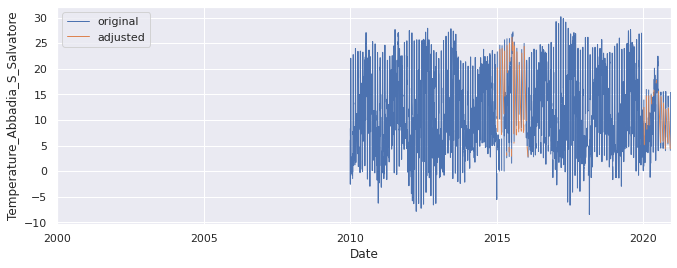

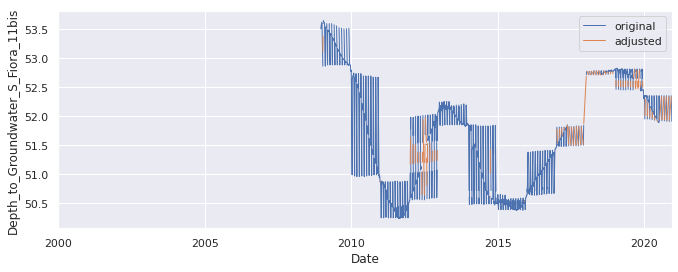

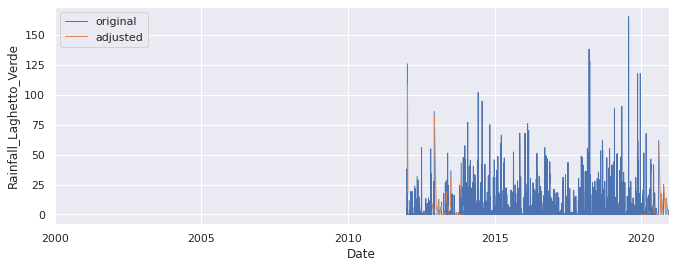

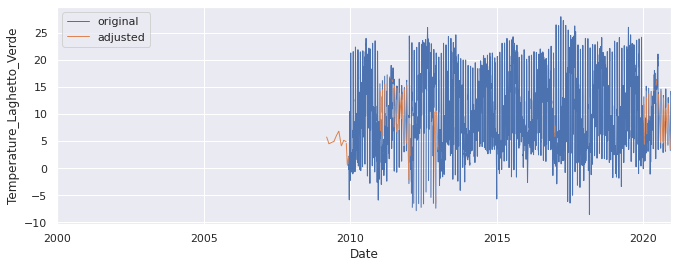

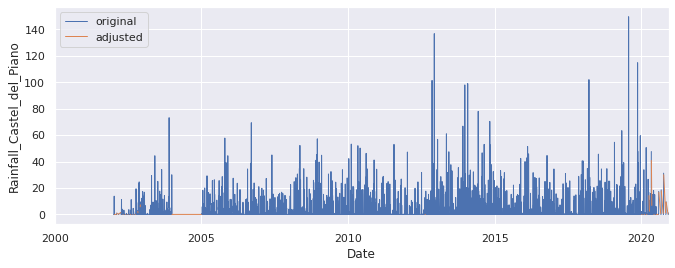

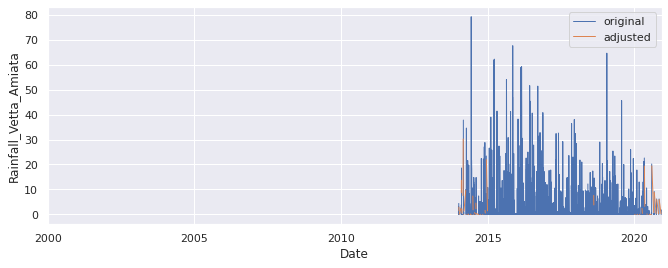

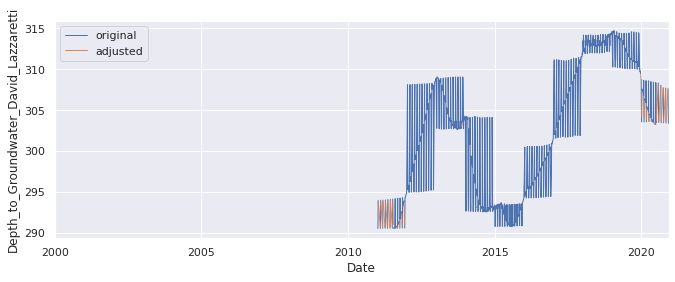

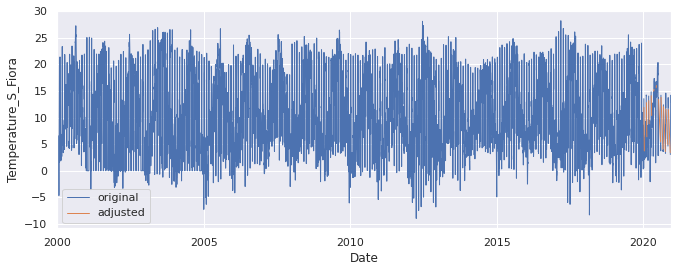

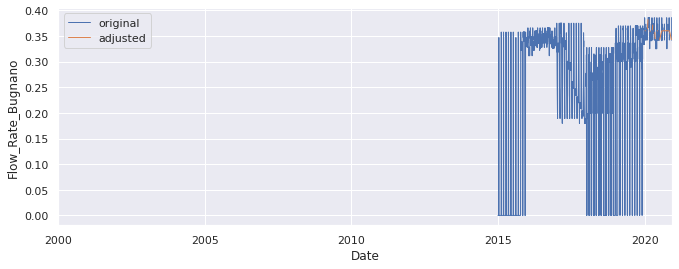

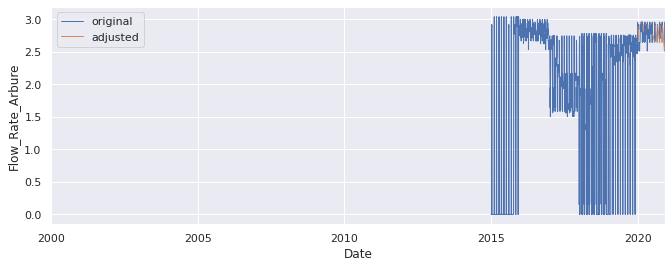

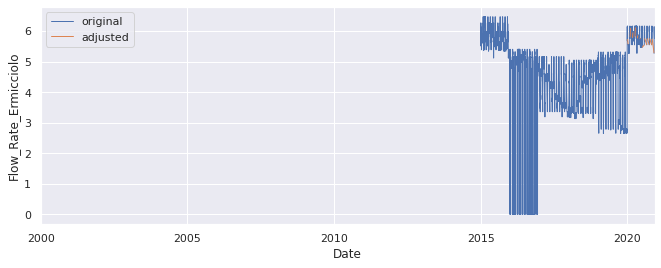

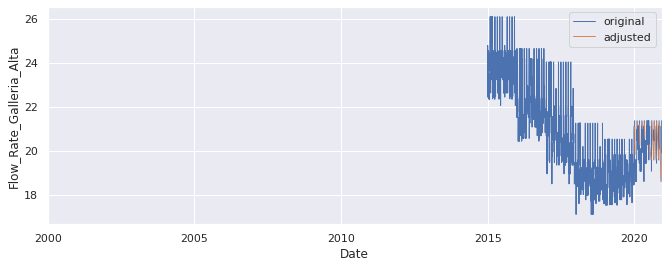

In [22]:
ws_amiata_adjusted = ws_amiata.copy() 
ws_amiata_adjusted = ws_amiata_adjusted.interpolate()

for index, row in ws_amiata_na_perc.iterrows():
  s1 = ws_amiata_adjusted[index].rename("full_adjusted")
  s2 = ws_amiata[index].rename("original")
  df = pd.concat([s1, s2], axis=1)
  df['adjusted'] = np.where(s2.isna(), s1, np.nan)
  df = df.drop(columns=['full_adjusted'])

  ax = df.plot(linewidth=1, subplots=False)
  ax.set(xlabel='Date', ylabel=index)

plt.show()

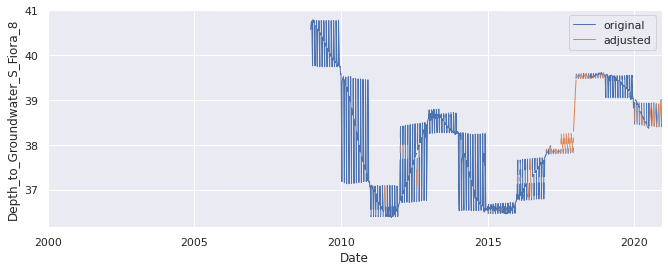

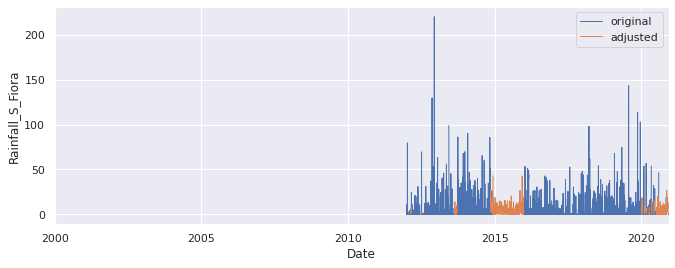

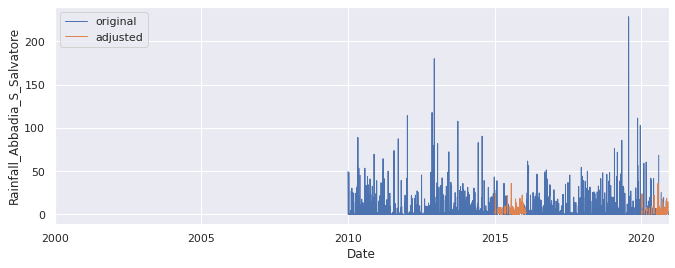

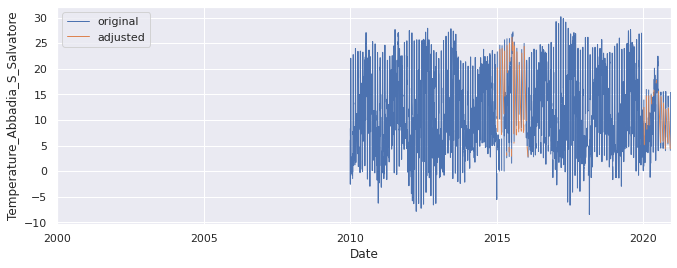

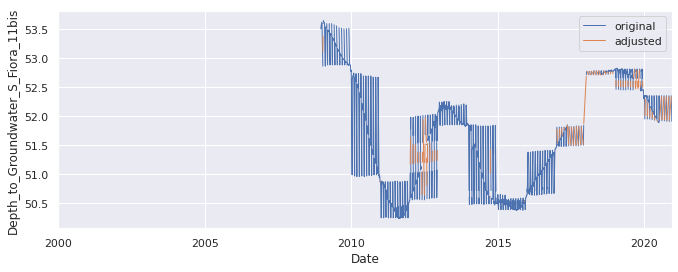

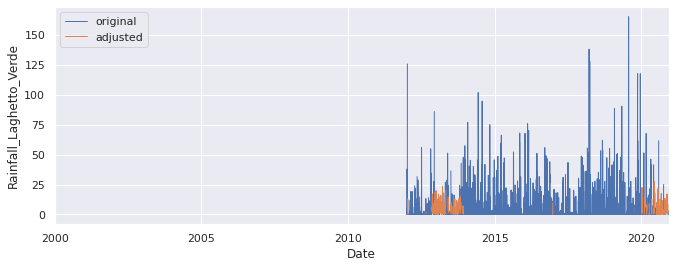

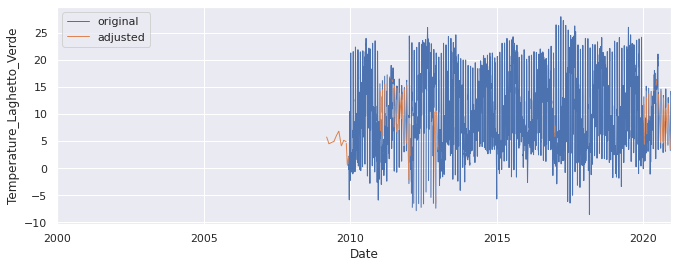

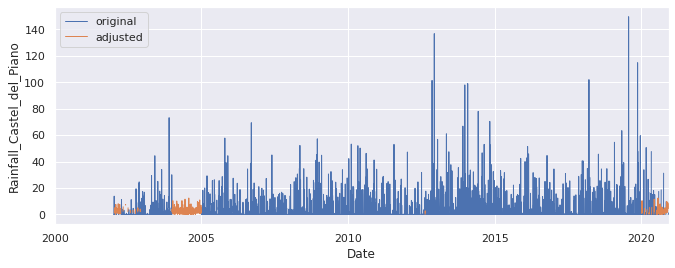

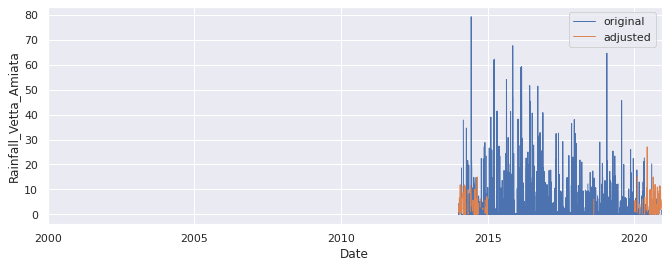

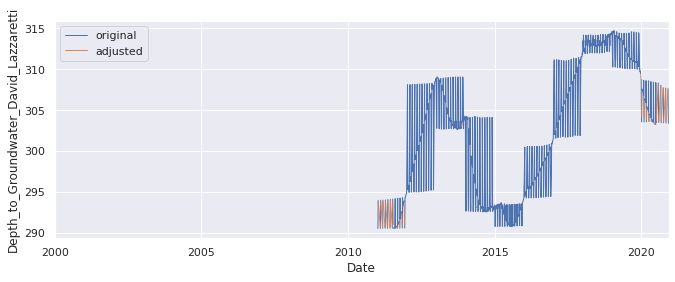

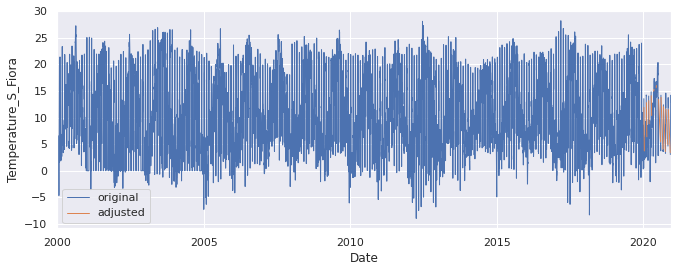

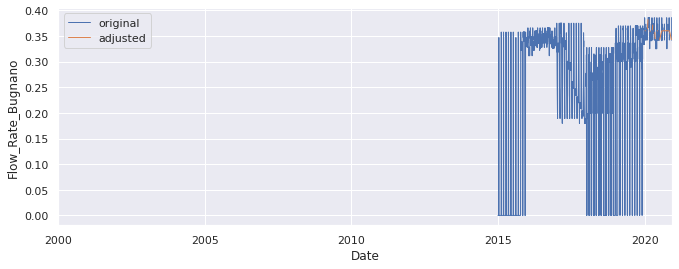

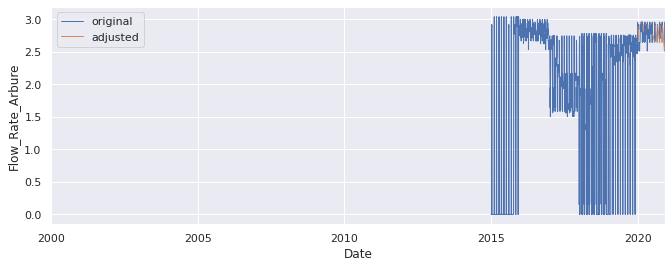

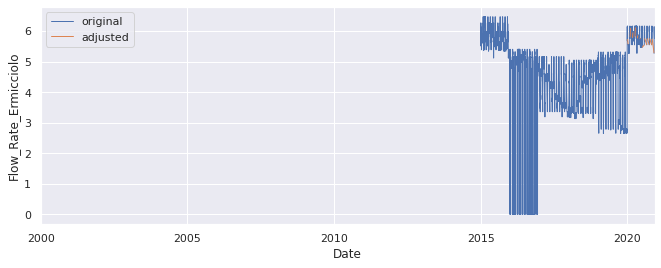

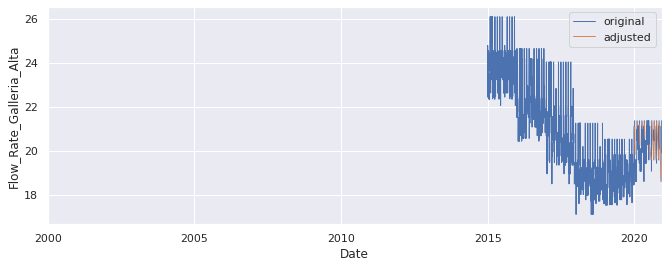

In [23]:
ws_amiata_adjusted = ws_amiata.copy() 

#For rainfall the interpolation wasn't effective, for this reason, we will use month mean of previous years
for c in ws_amiata_rainfall_cols:
  first_valid = ws_amiata[ws_amiata[c].notnull()][c].index[0]
  tmp = ws_amiata_adjusted.loc[first_valid:][c]
  ws_amiata_adjusted[c] = tmp.groupby([tmp.index.month, tmp.index.day]).transform(lambda x: x.fillna(x.mean()))

ws_amiata_adjusted = ws_amiata_adjusted.interpolate()

for index, row in ws_amiata_na_perc.iterrows():
  s1 = ws_amiata_adjusted[index].rename("full_adjusted")
  s2 = ws_amiata[index].rename("original")
  df = pd.concat([s1, s2], axis=1)
  df['adjusted'] = np.where(s2.isna(), s1, np.nan)
  df = df.drop(columns=['full_adjusted'])

  ax = df.plot(linewidth=1, subplots=False)
  ax.set(xlabel='Date', ylabel=index)

plt.show()

In [24]:
ws_amiata_na_perc = pd.DataFrame(columns=['Percentage','Total NA Records'])
for c in list(ws_amiata_adjusted.columns):
  total = len(ws_amiata_adjusted.loc[ws_amiata_bg:, c])
  na = ws_amiata_adjusted.loc[ws_amiata_bg:, c].isna().sum()
  ws_amiata_na_perc.loc[c] = [round(na/total,4) if na > 0 else 0.0,na]

ws_amiata_na_perc = ws_amiata_na_perc.sort_values(by=['Percentage'], ascending=False)
ws_amiata_na_perc

,Percentage,Total NA Records
Rainfall_Castel_del_Piano,0.0,0.0
Rainfall_Abbadia_S_Salvatore,0.0,0.0
Rainfall_S_Fiora,0.0,0.0
Rainfall_Laghetto_Verde,0.0,0.0
Rainfall_Vetta_Amiata,0.0,0.0
Depth_to_Groundwater_S_Fiora_8,0.0,0.0
Depth_to_Groundwater_S_Fiora_11bis,0.0,0.0
Depth_to_Groundwater_David_Lazzaretti,0.0,0.0
Temperature_Abbadia_S_Salvatore,0.0,0.0
Temperature_S_Fiora,0.0,0.0


### Final Cut

In [25]:
ws_amiata_adjusted = ws_amiata_adjusted.loc[ws_amiata_bg:ws_amiata_ed]
ws_amiata_adjusted.head(5)

,Rainfall_Castel_del_Piano,Rainfall_Abbadia_S_Salvatore,Rainfall_S_Fiora,Rainfall_Laghetto_Verde,Rainfall_Vetta_Amiata,Depth_to_Groundwater_S_Fiora_8,Depth_to_Groundwater_S_Fiora_11bis,Depth_to_Groundwater_David_Lazzaretti,Temperature_Abbadia_S_Salvatore,Temperature_S_Fiora,Temperature_Laghetto_Verde,Flow_Rate_Bugnano,Flow_Rate_Arbure,Flow_Rate_Ermicciolo,Flow_Rate_Galleria_Alta
2015-01-01,0.0,0.00,0.050000,0.0,0.0,36.57,50.65,292.95,-2.30,-2.40,-2.25,0.0,0.0,5.906212,23.510146
2015-01-02,12.8,11.60,9.425000,16.0,10.8,36.57,50.51,293.33,-0.45,-0.05,-0.40,0.0,0.0,6.145795,24.785076
2015-01-03,0.0,6.04,6.457143,0.0,0.0,36.62,50.55,293.45,5.10,4.05,3.45,0.0,0.0,5.514933,22.433296
2015-01-04,0.0,0.00,1.050000,0.0,0.0,36.54,50.48,293.37,10.65,10.00,9.75,0.0,0.0,6.268589,24.467522
2015-01-05,0.0,0.00,4.714286,0.0,0.0,36.55,50.48,292.23,10.25,8.90,8.90,0.0,0.0,6.238023,23.529615


## Exploratory Data Analysis (EDA)

### Analysing peaks

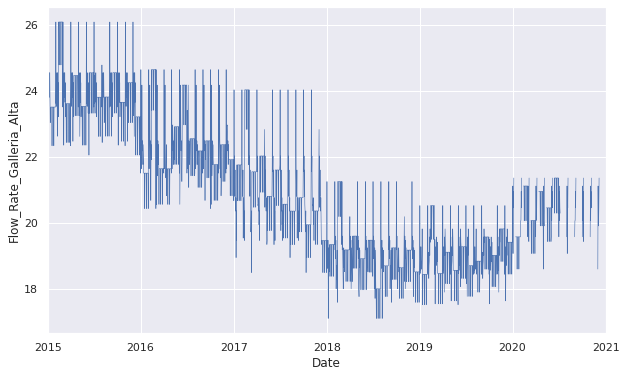

In [26]:
ax = ws_amiata['Flow_Rate_Galleria_Alta'].plot(linewidth=0.6, subplots=False, figsize=(10, 6))
plot_dt_range = [datetime.date(2015, 1, 1), datetime.date(2021, 1, 1)]
ax.set_xlim(plot_dt_range)
ax.set(xlabel='Date', ylabel=index)

plt.show()

### Correlation Matrix

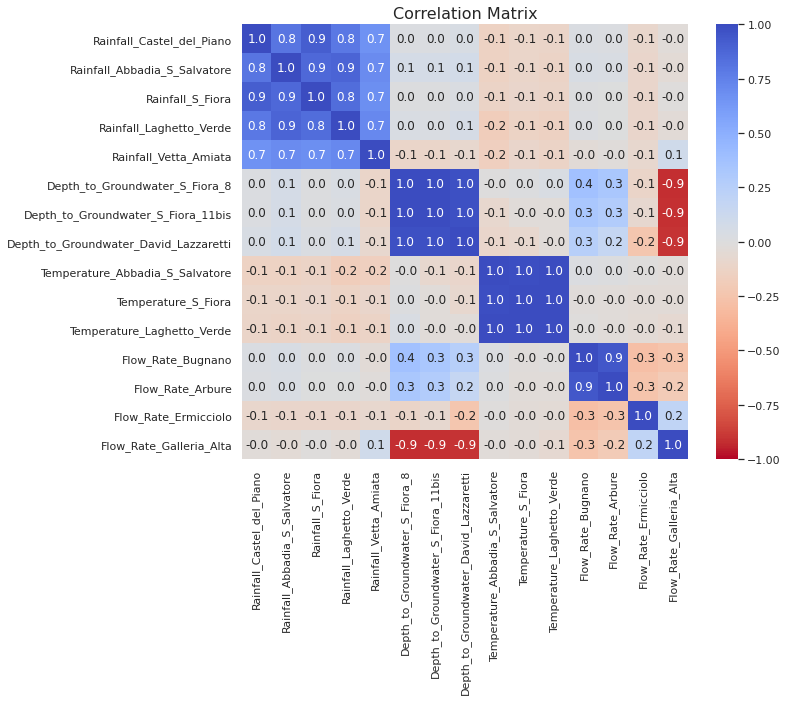

In [27]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(10, 8))
corrmat = ws_amiata[list(ws_amiata.columns)].corr()

ax = sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, fmt='.1f', cmap='coolwarm_r')
ax.set_title('Correlation Matrix', fontsize=16);

## Feature Engineering

In [28]:
ws_amiata_decompose = seasonal_decompose(ws_amiata_adjusted, model = 'additive', freq=365, extrapolate_trend='freq') #365 #additive

ws_amiata_decompose_seasonal = ws_amiata_decompose.seasonal
ws_amiata_decompose_seasonal.columns = [s + '_Seasonal' for s in list(ws_amiata_decompose_seasonal)]

ws_amiata_decompose_trend = ws_amiata_decompose.trend
ws_amiata_decompose_trend.columns = [s + '_Trend' for s in list(ws_amiata_decompose_trend)]

ws_amiata_decompose_resid = ws_amiata_decompose.resid
ws_amiata_decompose_resid.columns = [s + '_Residual' for s in list(ws_amiata_decompose_resid)]

ws_amiata_adjusted_decomposed = pd.concat([ws_amiata_decompose_seasonal, ws_amiata_decompose_trend, ws_amiata_decompose_resid], axis=1)
ws_amiata_adjusted_decomposed.head(5)

,Rainfall_Castel_del_Piano_Seasonal,Rainfall_Abbadia_S_Salvatore_Seasonal,Rainfall_S_Fiora_Seasonal,Rainfall_Laghetto_Verde_Seasonal,Rainfall_Vetta_Amiata_Seasonal,Depth_to_Groundwater_S_Fiora_8_Seasonal,Depth_to_Groundwater_S_Fiora_11bis_Seasonal,Depth_to_Groundwater_David_Lazzaretti_Seasonal,Temperature_Abbadia_S_Salvatore_Seasonal,Temperature_S_Fiora_Seasonal,Temperature_Laghetto_Verde_Seasonal,Flow_Rate_Bugnano_Seasonal,Flow_Rate_Arbure_Seasonal,Flow_Rate_Ermicciolo_Seasonal,Flow_Rate_Galleria_Alta_Seasonal,Rainfall_Castel_del_Piano_Trend,Rainfall_Abbadia_S_Salvatore_Trend,Rainfall_S_Fiora_Trend,Rainfall_Laghetto_Verde_Trend,Rainfall_Vetta_Amiata_Trend,Depth_to_Groundwater_S_Fiora_8_Trend,Depth_to_Groundwater_S_Fiora_11bis_Trend,Depth_to_Groundwater_David_Lazzaretti_Trend,Temperature_Abbadia_S_Salvatore_Trend,Temperature_S_Fiora_Trend,Temperature_Laghetto_Verde_Trend,Flow_Rate_Bugnano_Trend,Flow_Rate_Arbure_Trend,Flow_Rate_Ermicciolo_Trend,Flow_Rate_Galleria_Alta_Trend,Rainfall_Castel_del_Piano_Residual,Rainfall_Abbadia_S_Salvatore_Residual,Rainfall_S_Fiora_Residual,Rainfall_Laghetto_Verde_Residual,Rainfall_Vetta_Amiata_Residual,Depth_to_Groundwater_S_Fiora_8_Residual,Depth_to_Groundwater_S_Fiora_11bis_Residual,Depth_to_Groundwater_David_Lazzaretti_Residual,Temperature_Abbadia_S_Salvatore_Residual,Temperature_S_Fiora_Residual,Temperature_Laghetto_Verde_Residual,Flow_Rate_Bugnano_Residual,Flow_Rate_Arbure_Residual,Flow_Rate_Ermicciolo_Residual,Flow_Rate_Galleria_Alta_Residual
2015-01-01,-1.987989,-1.509051,-3.087503,-2.910992,-0.991566,0.322337,0.239677,0.763476,-8.728149,-8.681529,-8.466257,0.018372,0.360094,-0.124867,-1.052929,1.834850,2.898477,4.312509,3.151848,3.027796,36.160965,50.134544,289.162587,15.509572,11.870164,11.254602,-0.048267,-0.342854,7.177307,24.638498,0.153139,-1.389426,-1.175006,-0.240855,-2.036229,0.086697,0.275780,3.023937,-9.081423,-5.588635,-5.038345,0.029895,-0.017240,-1.146227,-0.075423
2015-01-02,1.261305,0.337771,-0.688138,1.439401,0.007167,0.357160,0.237240,1.104461,-8.266618,-7.169849,-7.005553,0.020576,0.339897,-1.386527,-0.045986,1.837391,2.901263,4.312335,3.154820,3.030385,36.162875,50.136162,289.177352,15.504905,11.869253,11.253854,-0.047486,-0.336499,7.170472,24.634256,9.701304,8.360966,5.800803,11.405780,7.762449,0.049966,0.136598,3.048187,-7.688286,-4.749404,-4.648301,0.026911,-0.003399,0.361850,0.196805
2015-01-03,2.205618,2.406808,2.965749,1.315455,-3.249040,0.200459,0.166196,1.909033,-7.588041,-6.146905,-6.093065,0.060798,0.404170,0.228947,-0.416360,1.839932,2.904050,4.312162,3.157792,3.032973,36.164784,50.137781,289.192118,15.500238,11.868342,11.253106,-0.046705,-0.330143,7.163638,24.630015,-4.045551,0.729143,-0.820768,-4.473246,0.216066,0.254757,0.246023,2.348849,-2.812197,-1.671437,-1.710042,-0.014093,-0.074027,-1.877652,-1.780359
2015-01-04,0.337009,0.623322,-1.223378,-0.424897,-1.718213,0.249286,0.224506,2.202577,-3.194978,-1.607195,-1.719528,0.057621,0.319834,0.375914,-0.564994,1.842474,2.906836,4.311988,3.160764,3.035562,36.166693,50.139399,289.206884,15.495571,11.867431,11.252358,-0.045924,-0.323787,7.156804,24.625774,-2.179482,-3.530158,-2.038610,-2.735867,-1.317349,0.124021,0.116095,1.960539,-1.650593,-0.260237,0.217170,-0.011696,0.003953,-1.264129,0.406742
2015-01-05,0.597349,-1.020712,1.529250,-0.503878,-0.193962,0.277997,0.279373,2.324559,-3.385294,-2.647941,-2.411424,0.047208,0.201865,0.230170,-0.669576,1.845015,2.909623,4.311815,3.163736,3.038151,36.168603,50.141018,289.221649,15.490904,11.866521,11.251610,-0.045143,-0.317431,7.149970,24.621532,-2.442364,-1.888910,-1.126779,-2.659857,-2.844189,0.103400,0.059610,0.683792,-1.855609,-0.318579,0.059814,-0.002064,0.115567,-1.142117,-0.422341


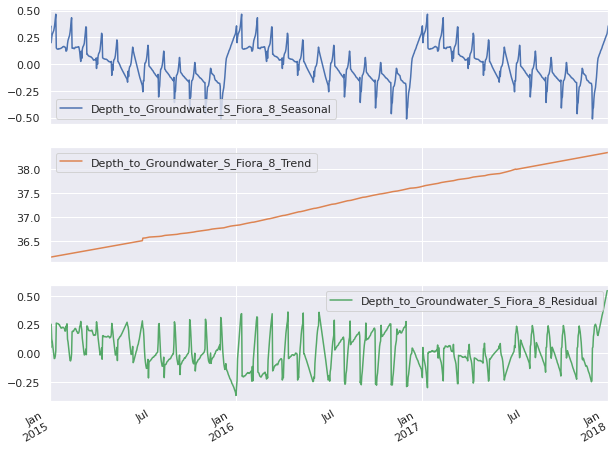

In [29]:
ws_amiata_depth_to_groundwater_s_fiora_8_cols = [i for i in list(ws_amiata_adjusted_decomposed.columns) if i.startswith('Depth_to_Groundwater_S_Fiora_8_')]
ws_amiata_adjusted_decomposed[ws_amiata_depth_to_groundwater_s_fiora_8_cols].plot(subplots=True, figsize=(10, 8));

## Feature Scaling - Flow Rate Arbure

In [30]:
attributes = [i for i in list(ws_amiata_adjusted_decomposed.columns) if not i.startswith('Flow_Rate_')]

ws_amiata_adjusted_features = ws_amiata_adjusted_decomposed[attributes]
ws_amiata_adjusted_flow_rate_arbure = ws_amiata_adjusted['Flow_Rate_Arbure']

ws_amiata_adjusted_features_np = ws_amiata_adjusted_features.to_numpy()
ws_amiata_adjusted_flow_rate_arbure_np = ws_amiata_adjusted_flow_rate_arbure.to_numpy()

In [31]:
sc_features = StandardScaler()
ws_amiata_adjusted_scaled_features_np = sc_features.fit_transform(ws_amiata_adjusted_features_np)

sc_predict = StandardScaler()
ws_amiata_adjusted_scaled_flow_rate_arbure_np = sc_predict.fit_transform(ws_amiata_adjusted_flow_rate_arbure_np.reshape(-1, 1));

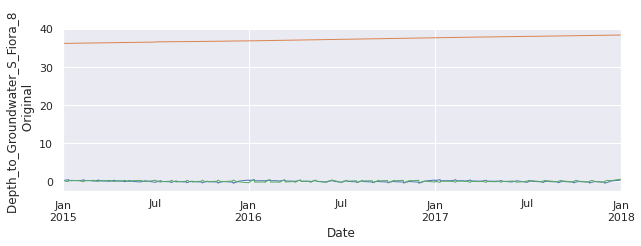

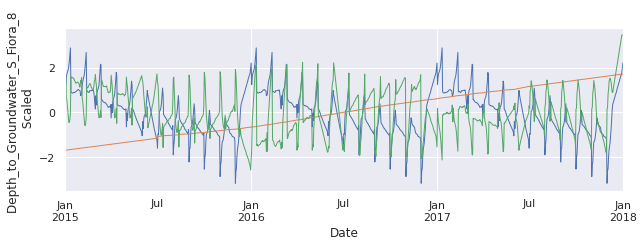

In [32]:
ws_amiata_adjusted_scaled_features_df = pd.DataFrame(data=ws_amiata_adjusted_scaled_features_np, 
                                                    columns=ws_amiata_adjusted_decomposed[attributes].columns,
                                                    index=ws_amiata_adjusted_decomposed[attributes].index)

ax = ws_amiata_adjusted_decomposed[ws_amiata_depth_to_groundwater_s_fiora_8_cols].plot(linewidth=1, subplots=False, figsize=(10, 3))
ax.set(xlabel='Date', ylabel='Depth_to_Groundwater_S_Fiora_8 \n Original')
ax.get_legend().remove()

ax = ws_amiata_adjusted_scaled_features_df[ws_amiata_depth_to_groundwater_s_fiora_8_cols].plot(linewidth=1, subplots=False, figsize=(10, 3))
ax.set(xlabel='Date', ylabel='Depth_to_Groundwater_S_Fiora_8 \n Scaled')
ax.get_legend().remove()

plt.show()

## LSTM - Flow Rate Arbure

In [33]:
# For reproducibility
import numpy as np
np.random.seed(4)
import tensorflow as tf
tf.random.set_seed(5)
from tensorflow import keras
import tensorflow.keras.backend as K

# Import Libraries and packages from Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.optimizers import Adam
from keras.optimizers import Nadam
from keras.optimizers import RMSprop
from tensorflow.keras import regularizers
from tensorflow.keras import initializers

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

In [34]:
#Creating a data structure with 90 timestamps and 1 output
X_train = []
y_train = []

n_future = 30 #Number of days we want to predict into the future
n_past = 90 #Number of past days we want to use to predict the future

for i in range(n_past, len(ws_amiata_adjusted_scaled_features_np) - n_future +1):
    X_train.append(ws_amiata_adjusted_scaled_features_np[i - n_past:i, 0:ws_amiata_adjusted_scaled_features_np.shape[1] - 1])
    y_train.append(ws_amiata_adjusted_scaled_flow_rate_arbure_np[i + n_future - 1:i + n_future, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))

X_train shape == (978, 90, 32).
y_train shape == (978, 1).


In [35]:
# Initializing the Neural Network based on LSTM
model = Sequential()

# Adding 1st LSTM layer
model.add(LSTM(units=12, return_sequences=True, input_shape=(n_past, X_train.shape[-1])))

# Adding 2nd LSTM layer
model.add(LSTM(units=6, return_sequences=False))

# Adding Dropout
model.add(Dropout(0.20))

# Output layer
model.add(Dense(units=1, activation='linear'))

model.compile(optimizer = Adam(learning_rate=0.0010, beta_1=0.99, beta_2=0.999), loss='mean_squared_error')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 90, 12)            2160      
_________________________________________________________________
lstm_1 (LSTM)                (None, 6)                 456       
_________________________________________________________________
dropout (Dropout)            (None, 6)                 0         
_________________________________________________________________
dense (Dense)                (None, 1)                 7         
Total params: 2,623
Trainable params: 2,623
Non-trainable params: 0
_________________________________________________________________


In [36]:
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=5, verbose=1, mode='min')
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=True, epochs=100, callbacks=[es, rlr, mcp, tb], validation_split=0.20, verbose=0, batch_size=64) 


Epoch 00001: val_loss improved from inf to 0.29142, saving model to weights.h5

Epoch 00002: val_loss improved from 0.29142 to 0.28475, saving model to weights.h5

Epoch 00003: val_loss improved from 0.28475 to 0.26401, saving model to weights.h5

Epoch 00004: val_loss improved from 0.26401 to 0.23166, saving model to weights.h5

Epoch 00005: val_loss improved from 0.23166 to 0.19734, saving model to weights.h5

Epoch 00006: val_loss improved from 0.19734 to 0.16325, saving model to weights.h5

Epoch 00007: val_loss improved from 0.16325 to 0.13729, saving model to weights.h5

Epoch 00008: val_loss improved from 0.13729 to 0.11995, saving model to weights.h5

Epoch 00009: val_loss improved from 0.11995 to 0.11119, saving model to weights.h5

Epoch 00010: val_loss improved from 0.11119 to 0.10848, saving model to weights.h5

Epoch 00011: val_loss improved from 0.10848 to 0.10813, saving model to weights.h5

Epoch 00012: val_loss improved from 0.10813 to 0.10752, saving model to weights

In [37]:
# Generate list of sequence of days for predictions
datelist_future = pd.date_range(list(ws_amiata_adjusted_decomposed.index)[-1], periods=n_future, freq='1d')
datelist_train = list(ws_amiata_adjusted_decomposed.index)[2 * n_past + n_future -1:]

In [38]:
# Perform predictions
predictions_future = model.predict(X_train[-n_future:])
predictions_train = model.predict(X_train[n_past:])

In [39]:
# Inverse the predictions to original measurements
y_pred_future = sc_predict.inverse_transform(predictions_future)
y_pred_train = sc_predict.inverse_transform(predictions_train)

In [40]:
y_pred_future_df = pd.DataFrame(y_pred_future, columns=['Flow_Rate_Arbure'], index=pd.to_datetime(datelist_future))
y_pred_train_df = pd.DataFrame(y_pred_train, columns=['Flow_Rate_Arbure'], index=pd.to_datetime(datelist_train))

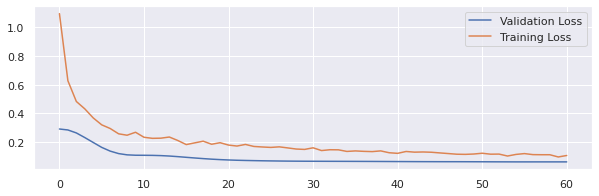

In [41]:
pd.DataFrame(data={'Validation Loss': history.history['val_loss'],
                   'Training Loss': history.history['loss']}).plot(figsize=(10, 3));
#https://machinelearningmastery.com/learning-curves-for-diagnosing-machine-learning-model-performance/

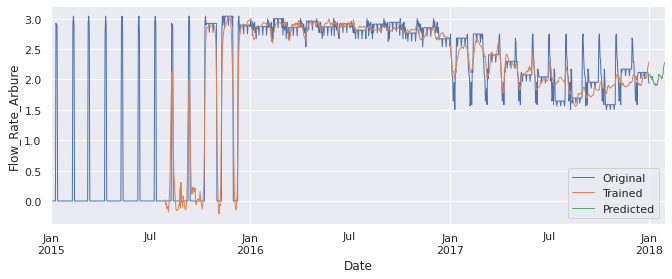

In [42]:
plot_dt_range = [datetime.date(2019, 1, 1), datetime.date(2020, 1, 1)]

final = pd.DataFrame(data={'Original': ws_amiata_adjusted['Flow_Rate_Arbure'], 
                           'Trained': y_pred_train_df['Flow_Rate_Arbure'],
                           'Predicted': y_pred_future_df['Flow_Rate_Arbure']})

ax = final.plot(linewidth=1, subplots=False)
#ax.set_xlim(plot_dt_range)
ax.set(xlabel='Date', ylabel='Flow_Rate_Arbure')

plt.show()

## Noise Analysis - Flow Rate Arbure

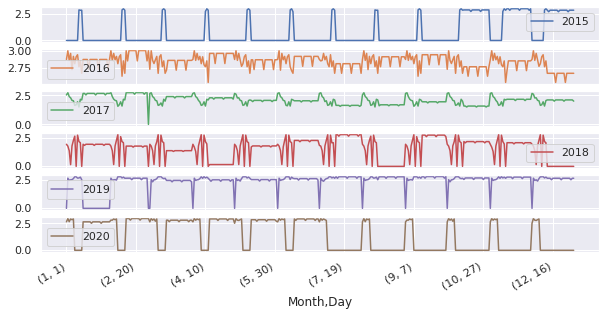

In [43]:
#df_flow_rate_arbure = pd.DataFrame
df_flow_rate_arbure = pd.DataFrame(ws_amiata['Flow_Rate_Arbure'])
df_flow_rate_arbure['Year'] = df_flow_rate_arbure.index.year
df_flow_rate_arbure['Month'] = df_flow_rate_arbure.index.month
df_flow_rate_arbure['Day'] = df_flow_rate_arbure.index.day
df_flow_rate_arbure.reset_index(drop=True, inplace=True)
df_flow_rate_arbure = df_flow_rate_arbure.pivot_table(index=['Month','Day'], columns='Year', values='Flow_Rate_Arbure').fillna(0)

df_flow_rate_arbure.plot(figsize=(10, 5), subplots=True);